In [1]:
%matplotlib inline
import matplotlib.pyplot as pp
import numpy as np
from scipy import signal
import librosa
import librosa.display
from IPython import display
from copy import deepcopy

# the pra library
import pyroomacoustics as pra

In [1]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

### Load sound

In [3]:
hello = Audio.fromfile("hello.wav")
print(hello.rate)
print(len(hello.data))
hello.play()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


44100
252864


In [4]:
orgdata = hello.data
orgdata.shape, orgdata

((252864,),
 array([ 0.01644897,  0.01644897,  0.01654053, ..., -0.00338745,
        -0.00326538, -0.00292969], dtype=float32))

In [5]:
byebye = Audio(Audio.fromfile("byebye.wav").data[:len(hello.data)], hello.rate)
print(len(byebye.data))
byebye.play()

252864


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Beamforming

###  one-line mics

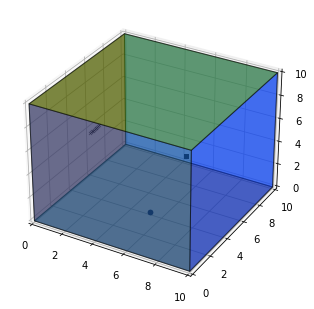

In [6]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 4.5, 5],
    [1, 4.6, 5],
    [1, 4.7, 5],
    [1, 4.8, 5],
    [1, 4.9, 5],
    [1, 5, 5],
    [1, 5.1, 5],
    [1, 5.2, 5],
    [1, 5.3, 5],
    [1, 5.4, 5],
    [1, 5.5, 5]
]


# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [7]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
mixdata = Audio(original_signal, room.fs).data
Audio(original_signal, room.fs).play()

In [8]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

### evaluation

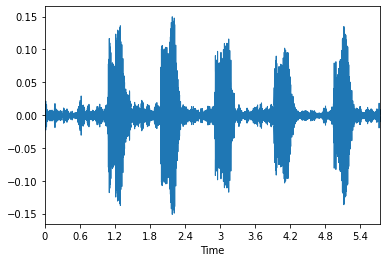

In [9]:
## hello.wav
hello.plot_wave()

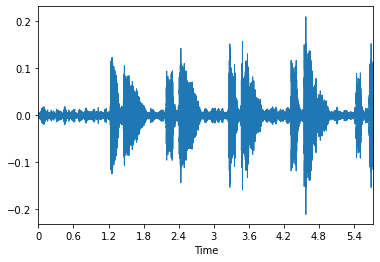

In [12]:
## byebyte.wav
byebye.plot_wave()

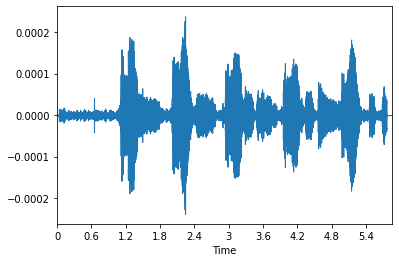

In [10]:
## BF
Audio(resulted_signal, room.fs).plot_wave()

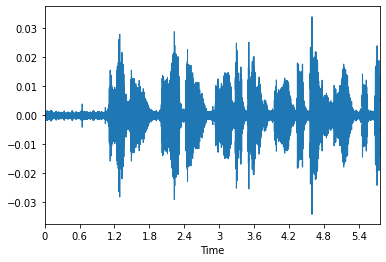

In [11]:
## Mix
Audio(original_signal, room.fs).plot_wave()

#### Cross-corelation evalution

In [13]:
# evaluate by cross-corelation
def corr(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    corr = signal.correlate(orgnorm[:length], bfnorm[:length])
    return corr

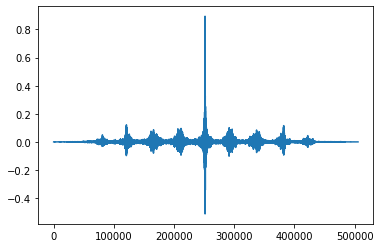

In [14]:
corr_1d = corr(orgdata, bfdata)
corr_1d
pp.plot(corr_1d)

#### Error evalution

In [15]:
# evaluate by calculating the errors
def error(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    error = ((orgnorm[:length] - bfnorm[:length]) ** 2).mean() ** 0.5
    return error

In [32]:
## 11 mics
err_1d = error(orgdata, hello.data)
err_1d

7.01649587650003e-09

In [33]:
## error of mixdata
err_mix = error(orgdata, mixdata)
err_mix

0.002948799696451754

---

#### SNR evalution

In [18]:
# calculate signal to noise ratio 
def SNR(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    est_noise = orgnorm[:length] - bfnorm[:length]
    snr = 10 * np.log10((np.sum(orgnorm**2))/(np.sum(est_noise**2)))
    return snr

In [19]:
SNR(orgdata, bfdata)

-3.1856023399520645

In [21]:
'''
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_1d = signaltonoise(bfdata, axis=0, ddof=0)
snr_1d
'''

'\n# calculate signal to noise ratio \ndef signaltonoise(Arr, axis=0, ddof=0):\n    Arr = np.asanyarray(Arr)\n    me = Arr.mean(axis)\n    sd = Arr.std(axis=axis, ddof=ddof)\n    #return np.where(sd == 0, 0, me/sd)\n    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))\n\nsnr_1d = signaltonoise(bfdata, axis=0, ddof=0)\nsnr_1d\n'

---

#### RMS evalution

In [22]:
# Compute the RMS ratio of the noise to the RMS of the original data (hello data).
orgdata = hello.data.flatten().astype('float')
bfdata = bfdata.flatten().astype('float')[:len(orgdata)]

# Normalize data
orgnorm = orgdata/np.linalg.norm(orgdata)
bfnorm = bfdata/np.linalg.norm(bfdata)


rms_noise = ((orgnorm - bfnorm) ** 2).mean() ** 0.5
rms_signal = ((orgnorm) ** 2).mean() ** 0.5
score = 1 - rms_noise / rms_signal
print("Your score: %.5f" % score)

Your score: -0.44371


----

### 2-D mics

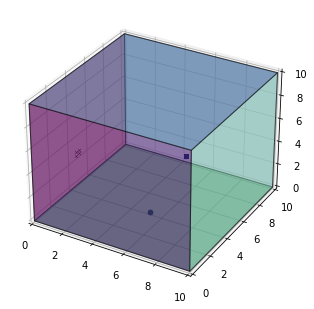

In [23]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 3, 4],
    [1, 3, 4.3],
    [1, 3.3, 4],
    [1, 3.3, 4.3]
    
#     [1, 3, 4],
#     [1, 3.5, 5],
#     [1, 5, 4],
#     [1, 5.5, 5]
#     [1, 4.9, 5],
#     [1, 5, 5],
#     [1, 5.1, 5],
#     [1, 5.2, 5],
#     [1, 5.3, 5],
#     [1, 5.4, 5],
#     [1, 5.5, 5]
]


# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [24]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
Audio(original_signal, room.fs).play()

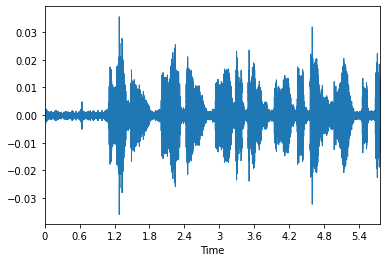

In [26]:
Audio(original_signal, room.fs).plot_wave()

In [25]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

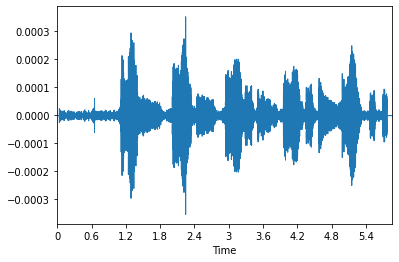

In [27]:
Audio(resulted_signal, room.fs).plot_wave()

### evaluation

In [29]:
## [1,1,1,1,1]
err_2d = error(orgdata, bfdata)
err_2d

0.002880038563759298

In [35]:
## [6,6,6,6,6]
err_2d = error(orgdata, hello.data)
err_2d

7.01649587650003e-09

---

In [36]:
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_2d = signaltonoise(bfdata, axis=0, ddof=0)
snr_2d

-89.102851855516

---

### spherical mics

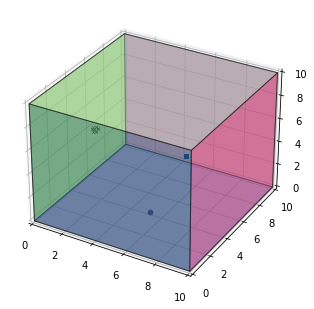

In [40]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
# center of array as column vector
mic_center = np.c_[[1, 5, 5]]

# microphone array radius
mic_radius = 0.2

# number of elements
mic_n = 12

# The GridSphere objects creates a number of points
# pseudo-uniformly spread on the unit sphere
grid = pra.doa.GridSphere(mic_n)

# The locations of the microphones can then be computed
R = mic_center + mic_radius * grid.cartesian

'''filter size'''
# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)

# Finally, we make the microphone array object as usual
# second argument is the sampling frequency
# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512

mics = pra.Beamformer(R, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)

#mics_ = pra.MicrophoneArray(R, room.fs)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [41]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
Audio(original_signal, room.fs).play()

In [42]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

### evaluation

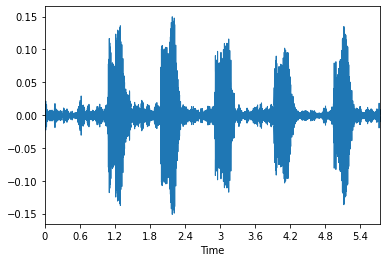

In [43]:
## hello.wav
hello.plot_wave()

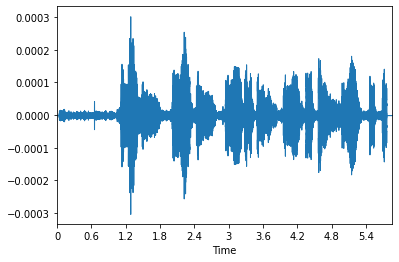

In [44]:
## BF
Audio(resulted_signal, room.fs).plot_wave()

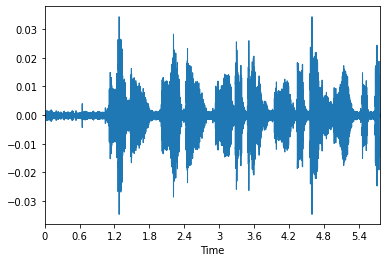

In [45]:
## Mix
Audio(original_signal, room.fs).plot_wave()

In [46]:
err_3d = error(orgdata, bfdata)
err_3d

0.0028594240961344673

In [47]:
err_1d, err_2d, err_3d

(7.01649587650003e-09, 7.01649587650003e-09, 0.0028594240961344673)

---

In [48]:
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_3d = signaltonoise(bfdata, axis=0, ddof=0)
snr_3d

-91.47367071400225